Test the d-thinning theory with the chip.
The theory only works under certain assumptions.
Let's apply those assumptions and validate that the theory is correct at least in that condition.
Real conditions, of course, may differ.

## Workflow
- Create a reasonable neuron population
 - optimize twiddle bits from calibration data
- Collect tuning to check neuron reasonability
- Turn off neurons whos spike rates are higher than some fraction of 6 / tau_syn 
- Collect and filter spikes at 0 input

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
DATA_DIR = "data/test_dthin/"
# set parameters for network
X = 64
Y = 64
NNEURON = X*Y
DIM = 1

# experimental parameters
TAU_READOUT = 0.0005
F_DISABLE = 0.9*1/TAU_READOUT/6 # max spike rate before disabling soma
BIN_SIZE_NS = 1000 # for testing
DAC_DIFF_R = 1024
DAC_DIFF_G = 1024
CLIP_TIME = 0.2 # how much of the initial data to discard

DOWNSTREAM_NS = 1000
UPSTREAM_NS   = 100000
PS = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = DIM,
)

In [3]:
hal = HAL()
net_builder = NetBuilder(hal)
calibrator = Calibrator(hal)

In [4]:
def build_tuning_net(ps_orig, net_builder, calibrator):
    d_matrix = np.zeros((2, Y*X))
    p_fname = (DATA_DIR + ps_orig.label + "_" + str(ps_orig.YX) + "_" +
               str(ps_orig.loc_yx) + "_" + str(ps_orig.D) + ".pck")
    ps, est_enc, est_off = utils.optimize_yield_w_cache(ps_orig, p_fname, calibrator)
    net = net_builder.create_single_pool_net_from_spec(ps, d_matrix)
    return net

net = build_tuning_net(PS, net_builder, calibrator)
run_control = RunControl(hal, net)
hal.map(net)
hal.set_DAC_value("DAC_DIFF_R", DAC_DIFF_R)
hal.set_DAC_value("DAC_DIFF_G", DAC_DIFF_G)

running sample sweep at sample_angle = 0.7853981633974483 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
354 neurons still need more points
running sample sweep at sample_angle = 0.39269908169872414 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
335 neurons still need more points
running sample sweep at sample_angle = 0.19634954084936207 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
332 neurons still need more points


/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:371: RuntimeWarning: invalid value encountered in less
  good_options_mask = (intercept_options < 1) & (intercept_options > -1)
/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:371: RuntimeWarning: invalid value encountered in greater
  good_options_mask = (intercept_options < 1) & (intercept_options > -1)


running sample sweep at sample_angle = 0.7853981633974483 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
1068 neurons still need more points
running sample sweep at sample_angle = 0.39269908169872414 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
957 neurons still need more points
running sample sweep at sample_angle = 0.19634954084936207 rad
  taking 8 sample points for 2 unique encs
  will run for 0.13333333333333333 min.
923 neurons still need more points


Collect spikes at 0 input

In [5]:
#  deliver an input of 0
def run_spikes_test(net, hal, run_control, bin_size_ns=100000):
    """Run a single input test trial"""
    hal.set_time_resolution(bin_size_ns//100, bin_size_ns)
    
    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns
    input_vals = {net.input:(input_times, input_rates)}

    _, spike_data = run_control.run_input_sweep(
        input_vals, get_raw_spikes=True, get_outputs=False)
    spikes, bin_times_ns = spike_data
    spikes = spikes[net.pool]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return spikes, bin_times
spikes, bin_times = run_spikes_test(net, hal, run_control)
# if np.sum(spikes[0]) > 2*spikes.shape[1]: # zero-out spikes that accumulated between traffic activation and exp
#     spikes[0] = 0

In [6]:
dt = bin_times[1] - bin_times[0]
tau = 0.01
filtered_spikes = lpf(spikes, tau, dt)
spike_rates = np.sum(spikes, axis=0) / (bin_times[-1] - bin_times[0])

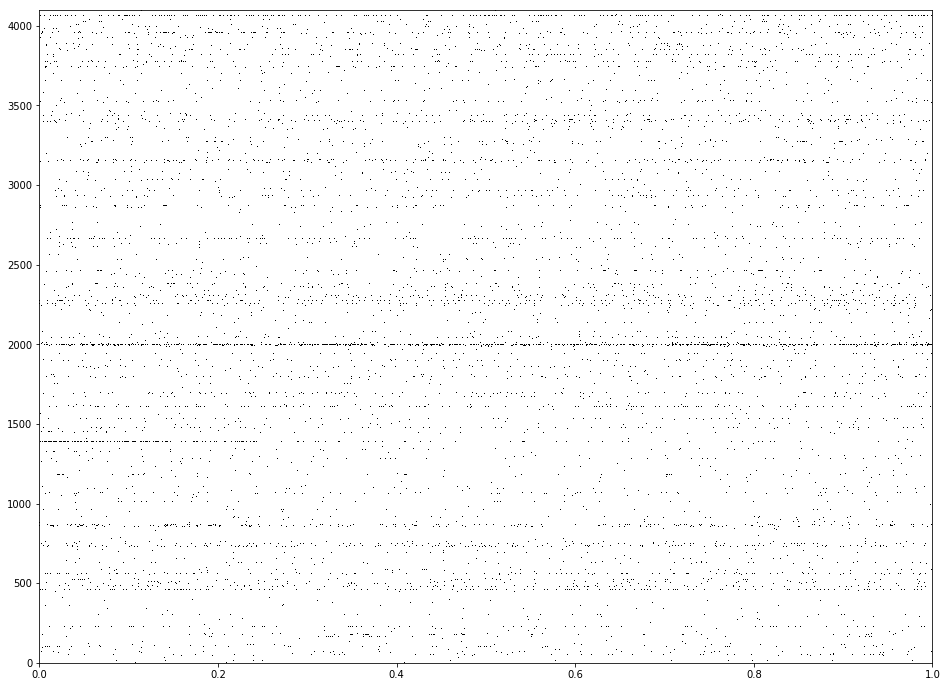

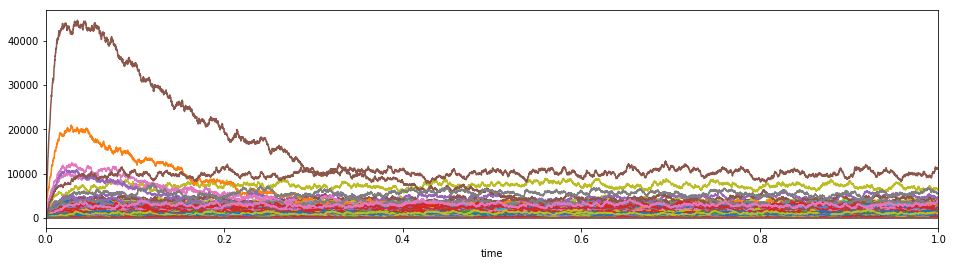

In [7]:
# make a raster of spikes
def plot_spike_raster_filter(spikes, filtered_spikes, bin_times):
    to_raster = spikes.copy()
    to_raster[to_raster>1] = 1
    plt.subplots(figsize=(16, 12))
    plot_spikes(bin_times, to_raster)

    plt.subplots(figsize=(16,4))
    for idx in range(spikes.shape[1]):
        plt.plot(bin_times, filtered_spikes[:, idx])
    plt.xlim((0, bin_times[-1]+bin_times[0]))
    plt.xlabel("time")
plot_spike_raster_filter(spikes, filtered_spikes, bin_times)

Some neurons are spiking very fast relative to the filter time constant. For the theory to align well with the experiment, we want $\lambda\tau<1$ and ideally $\lambda\tau<\frac{1}{6}$.

Find the neurons with high spike rates and set them to not spike.

disabling 692 neurons


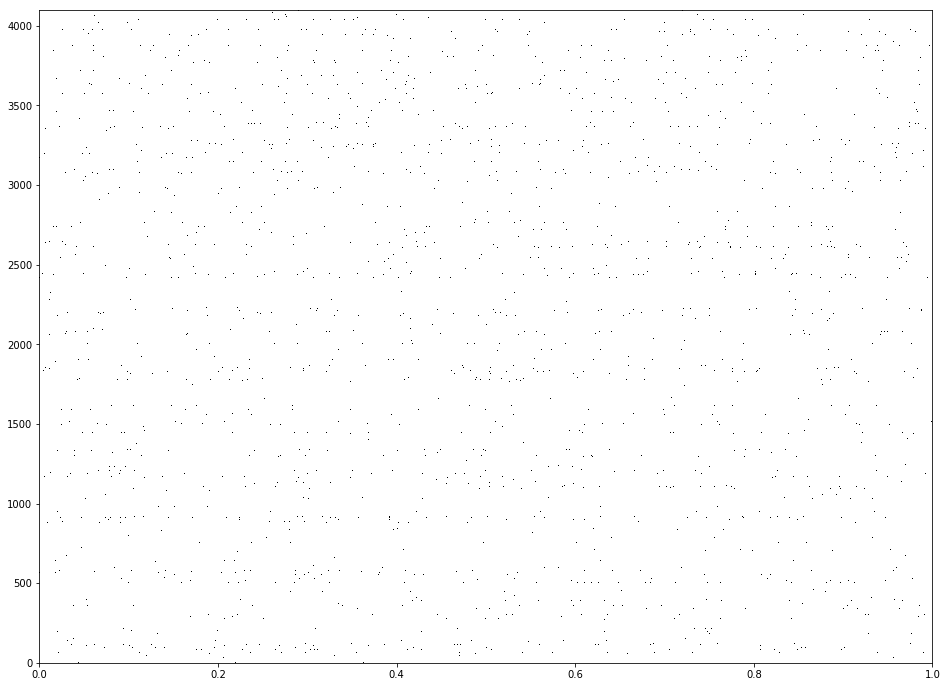

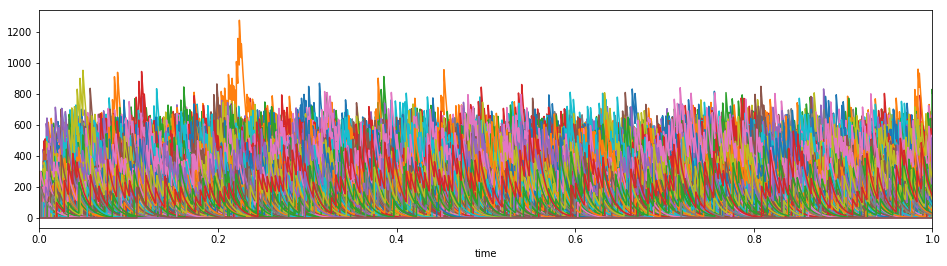

In [8]:
def disable_neurons(y, x, disable_y, disable_x):
    for y_idx, x_idx in zip(range(y), range(x)):
        hal.driver.EnableSomaXY(0, x_idx, y_idx)
    print("disabling {:d} neurons".format(len(disable_y)))
    for y_idx, x_idx in zip(disable_y, disable_x):
        hal.driver.DisableSomaXY(0, x_idx, y_idx)
    hal.flush()

# assume we'll be using a tau of 1ms
# compute spike rates 
# disable fast_spiking neurons, or maybe try upping their gain divisors
DISABLE_Y, DISABLE_X = np.nonzero((spike_rates > F_DISABLE).reshape((Y, X)))
disable_neurons(Y, X, DISABLE_Y, DISABLE_X)

spikes, bin_times = run_spikes_test(net, hal, run_control)
dt = bin_times[1] - bin_times[0]
tau = 0.01
filtered_spikes = lpf(spikes, tau, dt)
spike_rates = np.sum(spikes, axis=0) / (bin_times[-1] - bin_times[0])
plot_spike_raster_filter(spikes, filtered_spikes, bin_times)

# Fixed, All Positive Decode Weights

- compare to all weights positive and equal
- check for poissonness of superposed spike trains
- sweep decoder magnitude

In [9]:
def run_decode_test(net, hal, run_control, bin_size_ns=100000):
    """Run a single input test trial"""
    hal.set_time_resolution(DOWNSTREAM_NS, bin_size_ns)

    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns
    input_vals = {net.input:(input_times, input_rates)}

    output_data, _ = run_control.run_input_sweep(
        input_vals, get_raw_spikes=False, get_outputs=True)
    outputs, bin_times_ns = output_data
    outputs = outputs[net.output]
    spikes = outputs[:, 0]
    decodes = outputs[:, 1]

    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return decodes, spikes, bin_times

class DData:
    def __init__(self, decode, spikes, bin_times, dweights):
        self.decode = decode
        self.spikes = spikes
        self.bin_times = bin_times
        self.dweights = dweights

def dw_sweep_collect_data(dweights, net, run_control, hal, bin_size_ns):
    """Collect data from experiments that sweep across dweights"""
    dw_data = []    
    for dw in dweights:
        net.decoder_conn.reassign_weights(dw)
        hal.remap_weights()        
        hal.set_DAC_value("DAC_DIFF_R", DAC_DIFF_R)
        hal.set_DAC_value("DAC_DIFF_G", DAC_DIFF_G)
        disable_neurons(Y, X, DISABLE_Y, DISABLE_X)
        
        decode, spikes, bin_times = run_decode_test(net, hal, run_control, bin_size_ns=bin_size_ns)
        print("checking decoded-weighted spikes")
        decode = utils.check_bins(decode)
        print("checking summed spikes")
        spikes = utils.check_bins(spikes)
        dw_data += [DData(decode=decode, spikes=spikes, bin_times=bin_times, dweights=dw)]
    return dw_data

In [10]:
dweight_vals = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64]
# dweight_vals = [1, 1/2]
dweights = []
for dweight_val in dweight_vals:
    dweights.append(np.ones((2, Y*X)))
    dweights[-1][1] = dweight_val

ddata = dw_sweep_collect_data(dweights, net, run_control, hal, BIN_SIZE_NS)

disabling 692 neurons
checking decoded-weighted spikes
Collected 174971 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 825029
                   1 : 169180
                   2 : 5780
                   3 : 11
Sum(bins) = 180773
checking summed spikes
Collected 175027 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 824973
                   1 : 169283
                   2 : 5742
                   3 : 2
Sum(bins) = 180773
disabling 692 neurons
checking decoded-weighted spikes
Collected 89135 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 910865
                   1 : 89135
Sum(bins) = 89135
checking summed spikes
Collected 168809 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 831191
                   1 : 159349
                   2 : 9459
                   3 : 1
Sum(bins) = 178270
disabling 692 neurons
checking decoded-weighted spikes
Collected 44959 non-zero bins.
Bin stats (bin value : N bins)
  

In [11]:
def dw_sweep_analyze_data(ddata, dweight_vals, tau):
    for data, dw in zip(ddata, dweight_vals):
        decode = data.decode
        spikes = data.spikes
        bin_times = data.bin_times
        dt = bin_times[1] - bin_times[0]
        filtered_decode = lpf(decode, tau, dt)
        idx = bin_times>CLIP_TIME
        fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        mean = np.mean(filtered_decode[idx])
        var = np.var(filtered_decode[idx])
        snr = mean/np.sqrt(var)
        print("dw {:.6f} fin {:6.0f} fout {:6.0f} mean {:6.0f} var {:8.0f} snr {:5.2f}".format(
            dw, fin, fout, mean, var, snr))
        dspk_times = bin_to_spk_times(decode, bin_times)
        isi = np.diff(dspk_times)
        isi_cv = np.sqrt(np.var(isi)) / np.mean(isi)
        
        data.filtered_decode = filtered_decode
        data.fin, data.fout = (fin, fout)
        data.mean, data.snr = (mean, snr)
        data.dspk_times = dspk_times
        data.isi = isi
        data.isi_cv = isi_cv
    return ddata
ddata = dw_sweep_analyze_data(ddata, dweight_vals, TAU_READOUT)

dw 1.000000 fin 176843 fout 176843 mean 176851 var 158556270 snr 14.04
dw 0.500000 fin 176345 fout  88173 mean  88175 var 39640892 snr 14.00
dw 0.250000 fin 176778 fout  44194 mean  44200 var 10348904 snr 13.74
dw 0.125000 fin 175929 fout  21991 mean  21991 var  2808042 snr 13.12
dw 0.062500 fin 175733 fout  10984 mean  10984 var   950356 snr 11.27
dw 0.031250 fin 175579 fout   5486 mean   5487 var   489198 snr  7.85
dw 0.015625 fin 177168 fout   2768 mean   2768 var   367821 snr  4.56


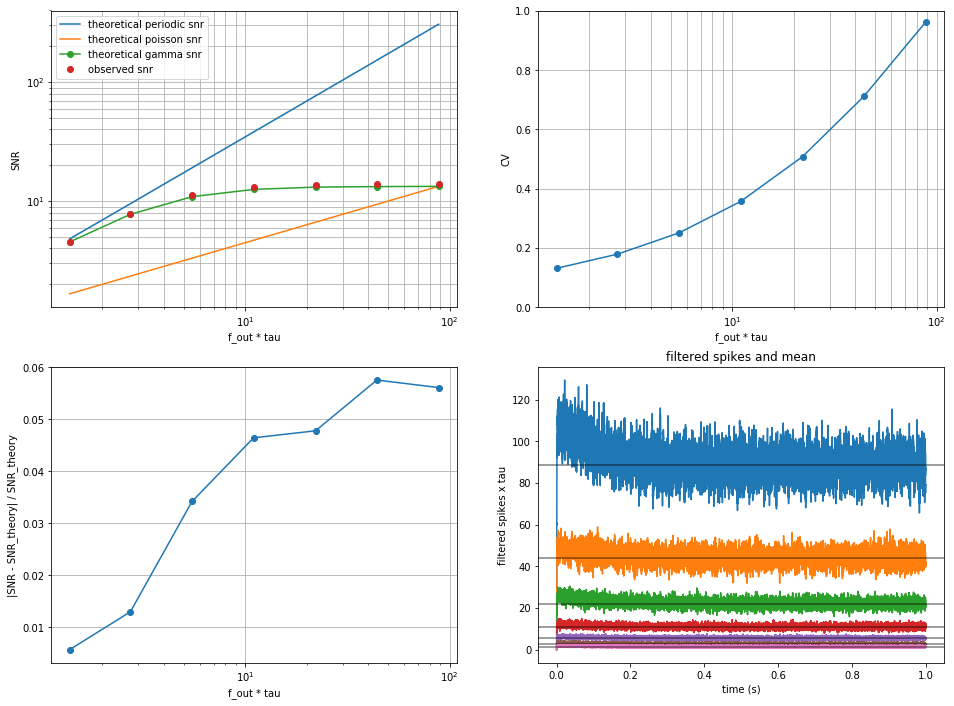

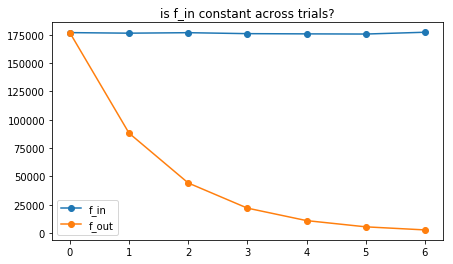

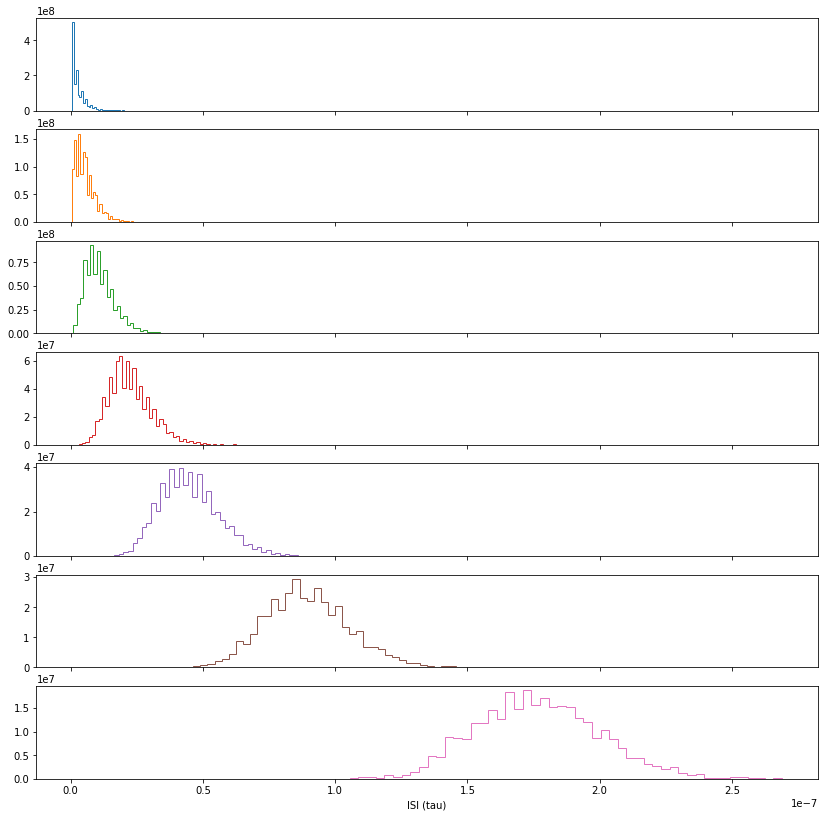

In [12]:
def dw_sweep_plot_data(ddata, dweight_vals, tau):
    fig_stats, axs_stats = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
    ax_snr, ax_cv = axs_stats[0]
    ax_snr_check, ax_filt = axs_stats[1]
    fig_exp, ax_f = plt.subplots(ncols=1, figsize=(7,4))
    fig_hist, axs_hist = plt.subplots(nrows=len(ddata), figsize=(14, 2*len(ddata)), sharex=True)
    
    fout = np.zeros(len(ddata))
    fin = np.zeros(len(ddata))
    snr = np.zeros(len(ddata))
    snr_th = np.zeros(len(ddata))
    isi_cv = np.zeros(len(ddata))
    for idx, (data, dw) in enumerate(zip(ddata, dweight_vals)):
        color = ax_filt.plot(data.bin_times, data.filtered_decode*tau)[0].get_color()
        ax_filt.axhline(data.mean*tau, color="k", alpha=0.5)
        fin[idx] = data.fin
        fout[idx] = data.fout
        snr[idx] = data.snr
        snr_th[idx] = utils.get_snr_gamma(data.fout*tau, 1/dw)
        isi_cv[idx] = data.isi_cv
        axs_hist[idx].hist(data.isi*tau, bins=50, cumulative=False, density=True, histtype="step", color=color)
    axs_hist[-1].set_xlabel("ISI (tau)")

    ax_filt.set_title('filtered spikes and mean')
    ax_filt.set_xlabel('time (s)')
    ax_filt.set_ylabel('filtered spikes x tau')
    fends = np.array([fout.min(), fout.max()])
    snr_poi = np.sqrt(2*fends*tau)
    snr_per_high_lt_appx = np.sqrt(12)*fends*tau
    snr_per = utils.get_snr_periodic(fout*tau)

    per_color = ax_snr.loglog(fout*tau, snr_per, label="theoretical periodic snr")[0].get_color()
    ax_snr.loglog(fends*tau, snr_per_high_lt_appx, color=per_color, alpha=0.2)
    ax_snr.loglog(fends*tau, snr_poi, label="theoretical poisson snr")
    ax_snr.loglog(fout*tau, snr_th, '-o', label="theoretical gamma snr")
    ax_snr.loglog(fout*tau, snr, 'o', label="observed snr")
    ax_snr.legend(loc="best")
    ax_snr.set_xlabel("f_out * tau")
    ax_snr.set_ylabel("SNR")
    ax_snr.grid(which="both")
    
    rel_snr = np.abs(snr-snr_th)/snr_th
    ax_snr_check.semilogx(fout*tau, rel_snr, '-o')
    ax_snr_check.grid()
    ax_snr_check.set_xlabel("f_out * tau")
    ax_snr_check.set_ylabel("|SNR - SNR_theory| / SNR_theory")

    ax_f.plot(fin, '-o', label="f_in")
    ax_f.plot(fout, '-o', label="f_out")
    ax_f.legend(loc="best")
    ax_f.set_title("is f_in constant across trials?")
    
    ax_cv.semilogx(fout*tau, isi_cv, '-o')
    ax_cv.set_ylim([0, 1])
    ax_cv.set_xlabel("f_out * tau")
    ax_cv.set_ylabel("CV")
    ax_cv.grid(which="both")
    
    return fout*tau, snr, snr_th
fouttau, snr, snr_th = dw_sweep_plot_data(ddata, dweight_vals, TAU_READOUT)

In [13]:
def dw_save_data(fouttau, snr, snr_th):
    """Save out the SNR vs fout data"""
    savedat = np.vstack([fouttau, snr, snr_th]).T
    fname = DATA_DIR + "fouttau_snr_{:d}_{:d}us.txt".format(Y*X, int(1000000*TAU_READOUT))
    np.savetxt(fname, savedat, header="fout*tau snr snr_th")
dw_save_data(fouttau, snr, snr_th)

In [14]:
# check that DAC values intended were actually set
print(hal.get_DAC_value("DAC_DIFF_R"))
print(hal.get_DAC_value("DAC_DIFF_G"))

1024
1024


checking decoded-weighted spikes
Collected 163458 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 836542
                   1 : 149654
                   2 : 13026
                   3 : 725
                   4 : 51
                   5 : 1
                   6 : 1
Sum(bins) = 178096
checking summed spikes
Collected 163458 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 836542
                   1 : 149654
                   2 : 13026
                   3 : 725
                   4 : 51
                   5 : 1
                   6 : 1
Sum(bins) = 178096
checking decoded-weighted spikes
Collected 88606 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 911394
                   1 : 88166
                   2 : 438
                   3 : 2
Sum(bins) = 89048
checking summed spikes
Collected 163458 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 836542
                   1 : 149654
                   2 : 130

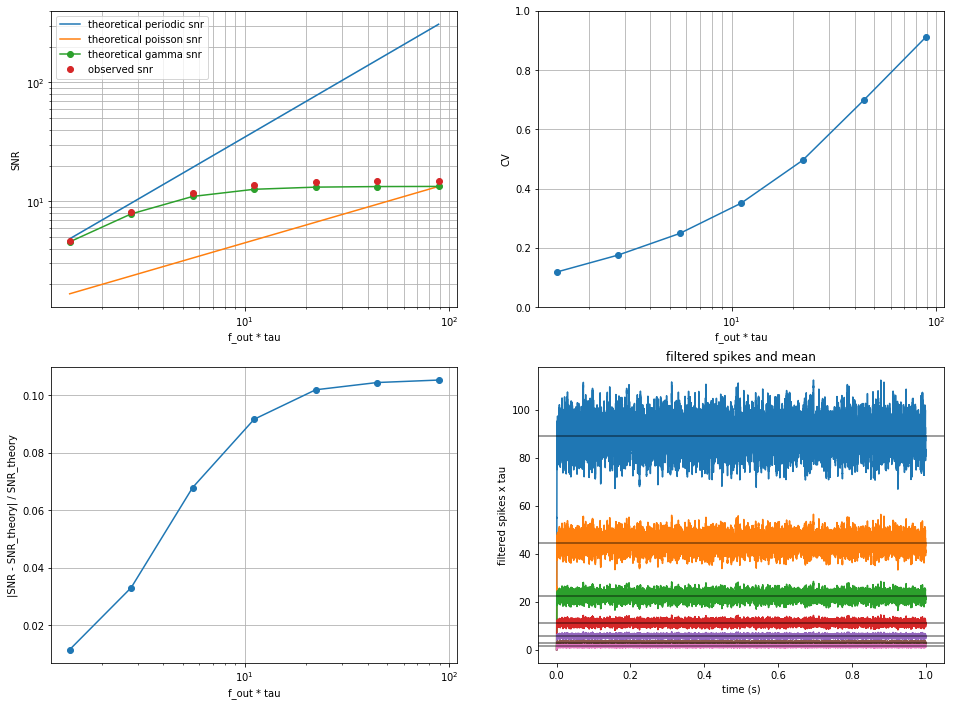

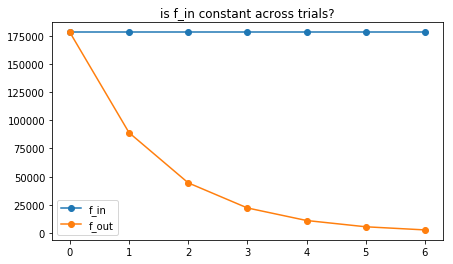

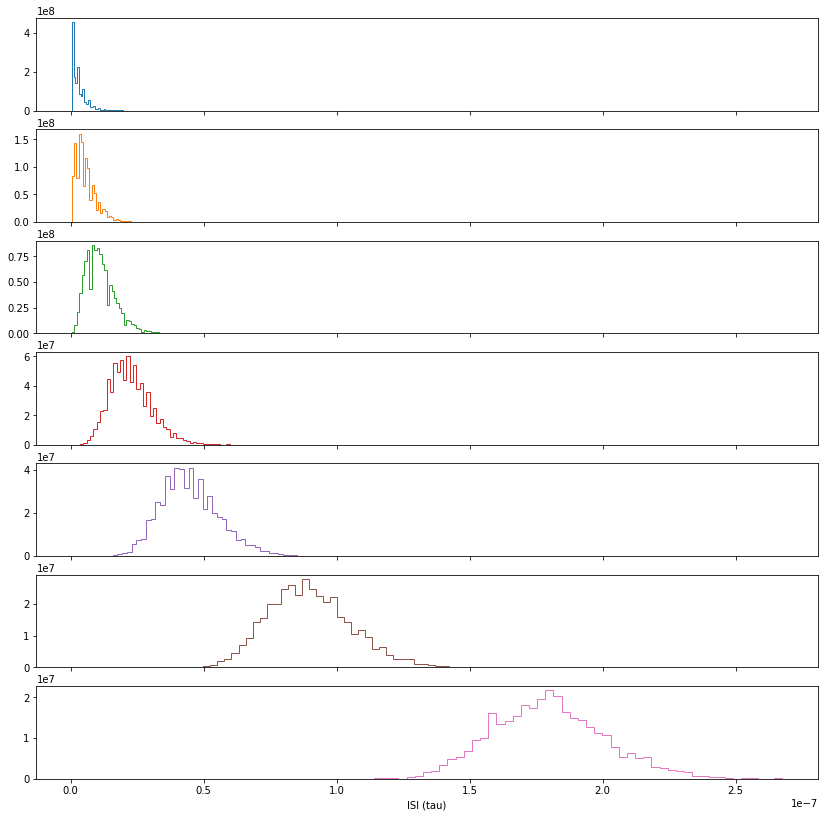

In [15]:
def sim_results(spike_rates, bin_times, dweights):
    """Simulate an experiment with the given parameters and see if it aligns with the observed
    
    Basically redo the analysis on fake data that matches the observed neurons spike rates
    """
    dt = bin_times[1]-bin_times[0]
    T = bin_times[-1]+dt
    
    def generate_spikes(spike_rates, dt, T):
        neuron_spikes = []
        merged_spikes = []
        for rate in spike_rates:
            if rate > 0:
                period = 1/rate
                offset = np.random.uniform(low=0, high=period)
                neuron_spikes += [list(period*np.arange(int((T-offset)/period)+1) + offset)]
                merged_spikes += neuron_spikes[-1]
            else:
                neuron_spikes += [[]]
        merged_spikes = np.sort(merged_spikes)
        return neuron_spikes, merged_spikes
    neuron_spikes, merged_spikes = generate_spikes(spike_rates, dt, T)

    def bin_spikes(neuron_spikes, dt):
        neuron_spikes_binned = np.zeros((len(bin_times), len(neuron_spikes)), dtype=int)
        for idx, spike_set in enumerate(neuron_spikes):
            bin_idxs = np.floor_divide(np.array(spike_set), dt).astype(int)
            bin_idxs, bin_cts = np.unique(bin_idxs, return_counts=True)
            neuron_spikes_binned[bin_idxs, idx] += bin_cts
        return neuron_spikes_binned
    neuron_spikes_binned = bin_spikes(neuron_spikes, dt)
    
    ## this segment explodes with very-fine bin size, have to rebin to make it work
    # tau = 0.01
    # filtered_spikes = lpf(neuron_spikes_binned, tau, dt)
    # plot_spike_raster_filter(neuron_spikes_binned, filtered_spikes, bin_times) # way to intensive
    # expect aliasing from the raster plot
    
    def simulate_decode(merged_spikes, dt, dweights):
        summed_spikes = bin_spikes([merged_spikes], dt).flatten()
        ddata = []
        for dw in dweights:
            skip = int(np.round(1/dw))
            decode = bin_spikes([merged_spikes[::skip]], dt).flatten()
            print("checking decoded-weighted spikes")
            decode = utils.check_bins(decode)
            print("checking summed spikes")
            spikes = utils.check_bins(summed_spikes)
            ddata += [DData(decode=decode, spikes=summed_spikes, bin_times=bin_times, dweights=dw)]
        return ddata
    ddata = simulate_decode(merged_spikes, dt, dweights)
    ddata = dw_sweep_analyze_data(ddata, dweight_vals, TAU_READOUT)
    dw_sweep_plot_data(ddata, dweight_vals, TAU_READOUT)

bin_times = ddata[0].bin_times
sim_results(spike_rates, bin_times, dweight_vals)